In [1]:
# 必要なライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import os
import re
import glob
import shutil
import gc
import pyarrow as pa
import dask as da
import dask.dataframe as dd
from pathlib import Path
from tqdm import tqdm

# matplotlibの日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# グラフの表示方法調整
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

# 乱数の種
random_seed = 123

<Figure size 864x360 with 0 Axes>

In [1]:
import sys
sys.path

['/Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction',
 '/Users/satoshiido/.vscode/extensions/ms-toolsai.jupyter-2022.7.1102252217/pythonFiles',
 '/Users/satoshiido/.vscode/extensions/ms-toolsai.jupyter-2022.7.1102252217/pythonFiles/lib/python',
 '/Users/satoshiido/miniforge3/envs/python38/lib/python38.zip',
 '/Users/satoshiido/miniforge3/envs/python38/lib/python3.8',
 '/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/lib-dynload',
 '',
 '/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages']

# 今回のコンペに関して

コンペ自体のデータサイズが大きいのでデータハンドリングが僕たちに取っては肝になりそうです（この辺をよく知っている人教えてください！）

### データの読み込みに関して
* 形式を変えたデータセットをpandasで読み込む
  * [`feather`形式](https://www.kaggle.com/datasets/munumbutt/amexfeather) or [`Parquet`形式](https://www.kaggle.com/datasets/odins0n/amex-parquet)
* [`pyspark`](https://www.kaggle.com/code/rakkaalhazimi/export-large-dataset-to-spark) or [`dask`](https://docs.dask.org/en/latest/dataframe.html) で読み込む

### サイズが大きい場合の対処方法は以下のkaggle notebookを参考にしてみてください

[> How to Work with BIG Datasets on 16G RAM (+Dask)](https://www.kaggle.com/code/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask)

上記notebookの内容概要
* TIP 1 - 使用していない変数を [`delete`](https://www.sejuku.net/blog/74447) するか & gc.collect()` で[ガベージコレクション](https://techacademy.jp/magazine/19437)(不要になったメモリ領域を開放して再利用する機能)をする
* TIP 2 - データセット内の各カラムのデータタイプを予め定義しておく
  * eg: 本来 float64 だったものを -> float32 と定義してサイズを圧縮する
* TIP 3 - 読み込むデータセットを選択する (including generating your own subsamples)
  * 読み込む行数を選ぶ
  * (`skiprows`) で[読み飛ばす行数を指定する](https://bit.ly/3O90Ze7)
  * 読み飛ばすリストを作成して、読み飛ばす（以下例）
    * ```
      skiplines = np.random.choice(np.arange(1, lines), size=lines-1-1000000, replace=False)
      skiplines=np.sort(skiplines)
      train = pd.read_csv('../input/train.csv', skiprows=skiplines, dtype=dtypes)
      ```
* TIP 4 - バッチ処理をする
  * ひとまとまりのデータに対して、一連の処理を連続で実行する処理方式のこと。大きなデータに関しても、設定したデータ数(チャンク)ごとに処理をする
* TIP 5 - 特定のカラムのみ `import` する
  * 450,000行 × 150カラム より 100万行 × 2カラム の方がメモリ消費が少ないことは容易に想像できる
* TIP 6 - groupby などの処理をするときも一部カラムの一部データのみにするˆ
* TIP 7 - `Dask` を使用する。
  * [DaskについてのQiita記事](https://qiita.com/simonritchie/items/e174f243bc03fb25462e)

## コンペの概要
* コンペ名：[American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction)

* 目的：毎月の顧客プロファイルから、顧客がクレジットカードの残高分を将来返済しない確率を予測すること
  * ターゲットのバイナリ変数は、最新のクレジットカード明細書から18ヶ月間のパフォーマンスウィンドウを観察することによって計算され、顧客が最新の明細書の日付から120日以内に支払額を支払わない場合、デフォルトとみなされる。

* 評価方法(Evaluation)
  * このコンペではクレカのデフォルト率を予測する。サブミットはちょっと特殊な評価方法で評価される。以下の通り:
    * ```
      M = 0.5*(G+D)  (*G = 正規化ジニ係数, D = デフォルト率 4% )
      ```
      機械学習における `正規化ジニ係数` は経済学などで使用される ジニ係数とは違うので注意です。以下記事を参照にしてみてください
      * [機械学習のモデル評価、説明可能性のための指標　その１。ジニ係数とAUC](https://qiita.com/Derek/items/4ded249f7a75f8da176c)
      * [DataRobot](https://docs.datarobot.com/ja/docs/modeling/reference/model-detail/opt-metric.html#gini-coefficient)
      * [GINI and AUC relationship](https://stats.stackexchange.com/questions/342329/gini-and-auc-relationship)
      * [Why use Normalized Gini Score instead of AUC as evaluation?](https://stats.stackexchange.com/questions/306287/why-use-normalized-gini-score-instead-of-auc-as-evaluation)

# データ管理環境整備

≒ディレクトリ整備

In [2]:
# # input_dir（input directory） を作る
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# INPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) を作る
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# OUTPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [3]:
# 一度やったらコメントアウトする

# # csvファイルを `data` ディレクトリ（=フォルダー） に移動させる
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*.csv'):
#     unique_dir_names.append(f)

# for file in list(set(unique_dir_names)):
#     print(f'moved file: {file}')
#     shutil.move(f'{file}', f'{INPUT_DIR}')

In [5]:
≈

# データ読み込み

前記の通り、データサイズが大きく、安易に `pandas` などを使ってもローカルではメモリが足りないので、ここではcsv形式を `parquet` 形式に変えてimport します

(*本来は自分でcsv -> parquet形式に変える必要がありますが、心優しい人がparquet形式にしてくれているのでそれを参照します。)
* [該当データダウンロードページ](https://www.kaggle.com/datasets/odins0n/amex-parquet)
* [Load Parquet Files with Low Memory](https://www.kaggle.com/code/odins0n/load-parquet-files-with-low-memory)
* [parquetデータを使用したEDA](https://www.kaggle.com/code/odins0n/amex-default-prediction-detailed-eda)

In [6]:
# parquet データを import
test = read_parquet('test')
train = read_parquet('train')
train_labels = read_csv('train_labels')
sample_sub = read_csv('sample_submission')

Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/test.parquet
Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/train.parquet
Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/train_labels.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/amex-default-prediction/data/sample_submission.csv


In [7]:
# ガベージコレクション
gc.collect()

0

In [12]:
# 以下のカラムは頻出と考えられ、毎回入力するのはめんどくさいので、ポップアップされるように定義します
customer_ID = 'customer_ID'
TARGET = 'target'

# 各テーブルの概説

* データについて
  * データセットには各顧客の特徴が各明細書日付ごとに集約されたものが含まれている。特徴は匿名化され、正規化されており、以下のカテゴリに分類されている（カラムの prefix を見ると分かる）:
    * D_*: Delinquency variables
    * S_*: Spend variables
    * P_*: Payment variables
    * B_*: Balance variables
    * R_*: Risk variables
  * 以下のカラムはカテゴリ変数である:
    * B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126

# EDA (データ確認)

> Daskを使えたらいいなあ

* [PythonのDaskをしっかり調べてみた（大きなデータセットを快適に扱う）](https://qiita.com/simonritchie/items/e174f243bc03fb25462e)

> EDA はこの辺もまずは参考にしてみる
* [AMEX EDA (Comparison of training and test data)](https://www.kaggle.com/code/onodera1/amex-eda-comparison-of-training-and-test-data)

## train data

In [8]:
train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 190 entries, customer_ID to D_145
dtypes: object(2), float32(93), int16(9), int8(86)

In [13]:
# カラム名をわかりやすくする
titles=['Delinquency '+str(i).split('_')[1] if i.startswith('D') 
        else 'Spend '+str(i).split('_')[1] if i.startswith('S') 
        else 'Payment '+str(i).split('_')[1] if i.startswith('P') 
        else 'Balance '+str(i).split('_')[1] if i.startswith('B') 
        else 'Risk '+str(i).split('_')[1] if i.startswith('R')
        else customer_ID
        for i in train.columns[:-1]
        ]

In [14]:
len(titles)

189

In [15]:
# train データのカラム名変更
titles.append('target')
train.columns = titles

In [16]:
# Target {0|1} 比率
train_target = pd.DataFrame(train[TARGET].value_counts()).reset_index()
train_target.columns = [TARGET, 'count']

fig = px.bar(data_frame = train_target, x=TARGET, y='count', width=600, height=400)
fig.update_traces(
                marker_color = ['#58D68D', '#DE3163'],
                marker_line_color = 'rgb(0,0,0)',
                marker_line_width=2)
fig.update_layout(
                title= 'Target 分布', 
                template = 'plotly_white',
                title_x = 0.5)

print('Target == 0 の比率: %0.2f%%' % (train_target["count"][0]*100 / (train_target["count"][0]+ train_target["count"][1])))
print('Target == 1 の比率: %0.2f%%' % (train_target["count"][1]*100 / (train_target["count"][0]+ train_target["count"][1])))

fig.show()

Target == 0 の比率: 92.38%
Target == 1 の比率: 7.62%


### 連続変数

In [34]:
# カテゴリ変数のリスト
cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'category']
COLS = list(train.columns[2:190])
# リスト形式で連続変数のみ抽出する
cont_cols = [col for col in COLS if col not in cat_cols and TARGET]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


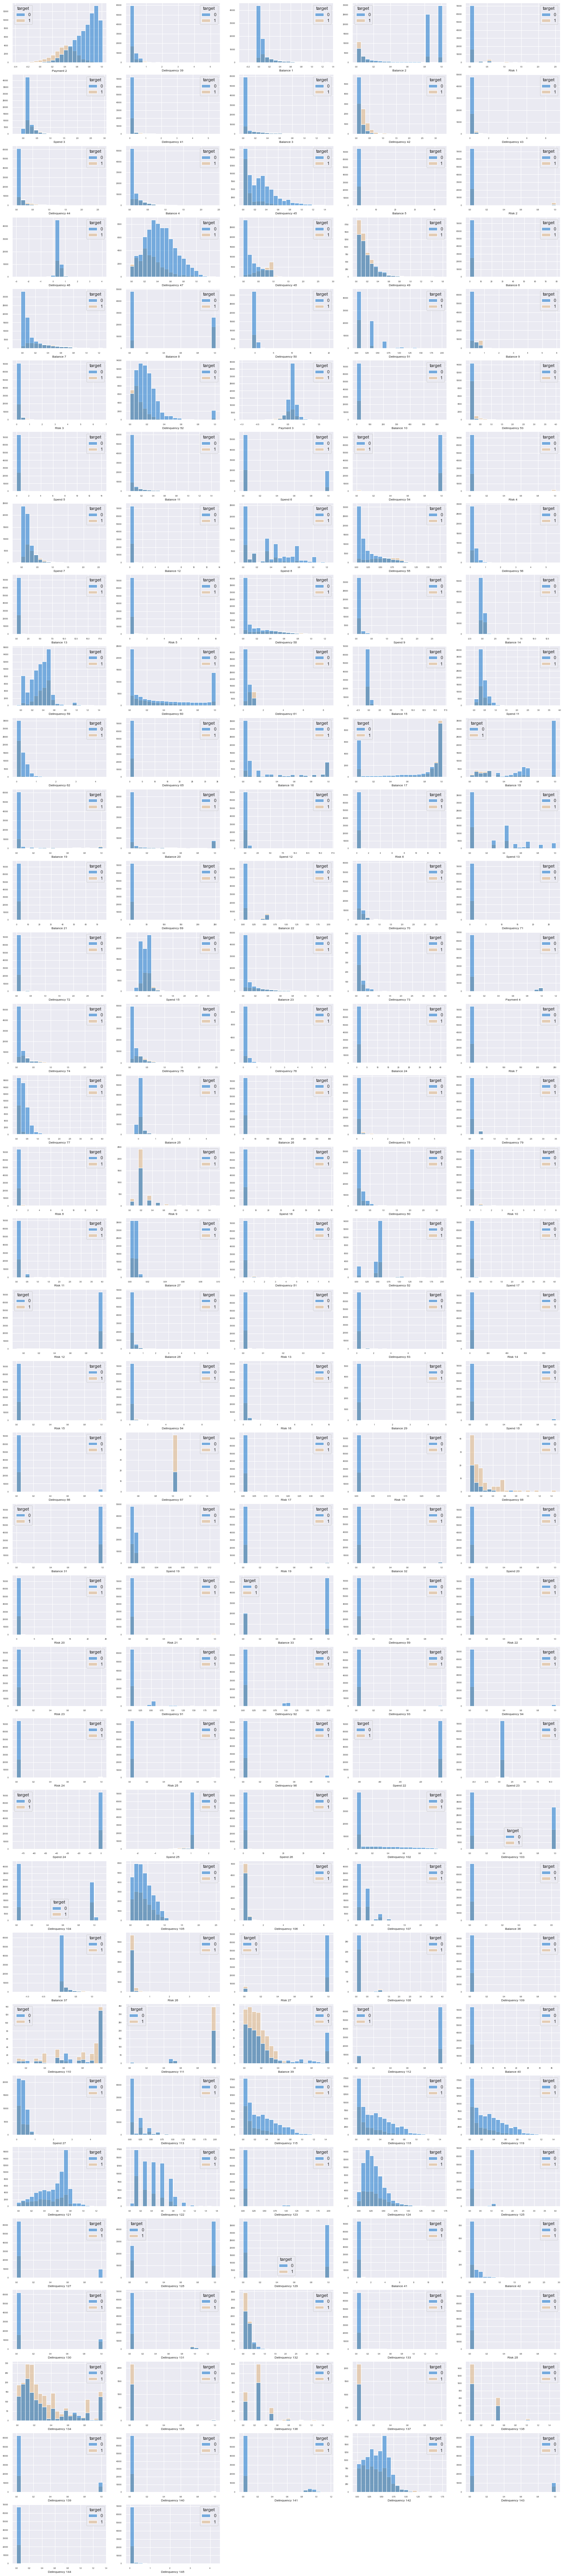

In [15]:
RANDOM_SPLIT = 100000
ncols = 5
nrows = 36
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 15*8))
# パレットカラーの指定
pal = ['#016CC9','#DEB078']
plt.legend(loc='upper right')

for r in range(nrows):
    for c in range(ncols):
        if r*ncols+c == len(cont_cols):
            break
        col = cont_cols[r*ncols+c]
        sns.histplot(data= train.iloc[:RANDOM_SPLIT],  x=col, ax=axes[r, c], hue= "target", bins = 20, palette =pal)
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8)
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(6)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
fig.delaxes(axes[35][2])
fig.delaxes(axes[35][3])   
fig.delaxes(axes[35][4])
plt.show()

### カテゴリ変数

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


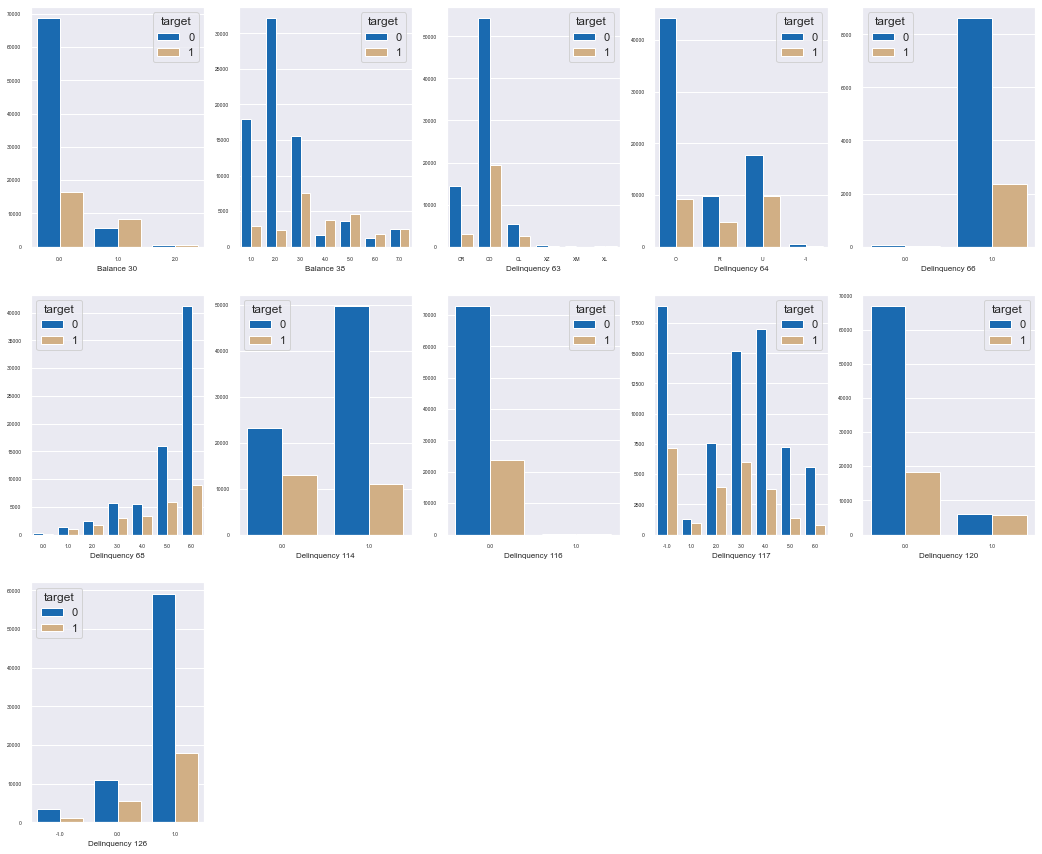

In [16]:
RANDOM_SPLIT = 100000
n_features = [col for col in cat_cols if col != 'category']
ncols = 5
nrows = int(len(n_features) / ncols + (len(COLS) % ncols > 0)) 
# パレットカラーの指定
pal = ['#016CC9','#DEB078']

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 15))
plt.legend(loc='upper right')
for r in range(nrows):
    for c in range(ncols):
        if r*ncols+c >= len(n_features):
            break
        col = n_features[r*ncols+c]
        sns.countplot(data=train.iloc[:RANDOM_SPLIT] , x = col, ax=axes[r, c], hue = "target", palette =pal)
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8)
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(6)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
fig.delaxes(axes[2][1])     
fig.delaxes(axes[2][2]) 
fig.delaxes(axes[2][3])
fig.delaxes(axes[2][4]) 
plt.show()

In [12]:
# ガベージコレクション
gc.collect()

0

## test data

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11363762 entries, 0 to 11363761
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(10), int8(85), object(2)
memory usage: 5.2+ GB


In [14]:
test.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.6313,0,0.0107,0.8145,0.0000,0.1687,0.0000,0.0023,0.1132,NaN,0,9,0.0045,0.0095,0,NaN,0.4744,0.6265,-1,0.1746,1.2507,1.0039,NaN,0,0.0010,1,0.1190,NaN,-0.0029,NaN,0.0028,0.0044,1,1.0000,0,0.1056,0.1192,996,0.1146,NaN,NaN,0,0.2059,NaN,0.0102,-1,0.0275,0.5887,0.0105,52,0.0518,0,-1,0,0,NaN,0.5921,0,-1,0,-1,0.1905,0.0027,415,0.0100,NaN,0,-1,0.0147,0,7,1.1348,0.1789,0.9595,3,3,NaN,0.0098,0.0000,0.0029,0.0069,0.0017,0,-1,0,-1,0.0025,0,0,0,0.0046,0,1,0.0051,1.0000,0.1338,0,-1,0.0000,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.0090,0,0,0,0,0,1,0,0,0,-1,0,0,0,0,0,0,0.9811,0.1349,0.9547,0.9711,0.0066,0.0024,-1,NaN,NaN,-1,-1,0.0081,0.0080,-1,NaN,1,-1,0,NaN,-1,NaN,1.0000,0.2742,0.0043,-1,-1,NaN,-1,-1,NaN,NaN,-1,NaN,-1,-1,-1,-1,1,0,NaN,-1,0,NaN,NaN,NaN,NaN,0.0071,0,NaN,-1,-1,-1,-1,-1,0,NaN,NaN,-1,0.0083,-1
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.5870,0,0.0110,0.8108,0.0000,0.2414,0.0000,0.0091,0.1230,NaN,0,10,0.0095,0.0263,0,NaN,0.4736,0.6117,-1,0.1771,0.2342,1.0093,NaN,0,0.0055,1,0.1210,NaN,0.0312,NaN,0.0065,0.0100,1,1.0000,0,0.1606,0.1215,528,0.1841,NaN,0.0283,0,0.4033,0.0145,0.0251,-1,0.0548,0.6229,0.0217,56,0.0576,0,-1,0,0,NaN,0.5909,0,-1,0,-1,0.1902,0.0018,574,0.0081,NaN,0,0,0.0119,0,9,0.2084,0.1795,0.9617,3,3,NaN,0.0045,0.0000,NaN,0.0037,0.0055,0,0,0,-1,0.0072,0,0,0,0.0096,0,1,0.0073,1.0000,0.1446,0,-1,0.0000,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.0051,0,0,0,0,0,1,0,0,0,-1,0,0,0,0,0,0,0.9670,0.1385,0.9570,0.9750,0.0046,0.0065,0,0.0000,NaN,-1,0,0.0001,0.0155,-1,1.0077,1,-1,0,NaN,-1,NaN,1.0000,0.3536,0.2766,-1,-1,NaN,-1,-1,NaN,NaN,-1,NaN,-1,-1,-1,-1,1,0,0.0000,0,0,NaN,0.0000,0.0000,NaN,0.0072,0,NaN,-1,-1,-1,-1,0,0,0.0000,NaN,0,0.0038,0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.6091,0,0.0164,1.0046,0.0000,0.2670,0.0000,0.0042,0.1253,NaN,0,10,0.0070,0.0600,0,NaN,0.4718,0.6222,-1,1.4171,0.1270,1.0046,NaN,0,0.0000,1,0.1131,NaN,0.0355,NaN,0.0034,0.0041,0,1.0000,0,0.2101,0.1201,528,0.2540,NaN,0.0337,0,0.3937,0.0229,0.0289,25,0.0837,0.6180,0.0393,46,0.0507,0,-1,0,0,NaN,0.5914,0,-1,0,-1,-0.0263,0.0072,711,0.0081,NaN,0,0,0.0156,0,9,0.1158,0.1824,0.9638,3,3,NaN,0.0041,0.0000,NaN,0.0024,0.0008,0,0,0,-1,0.0065,0,0,0,0.0066,0,1,0.0065,1.0000,0.1497,0,-1,0.0000,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.0026,0,0,0,0,0,1,0,0,0,-1,0,0,0,0,0,0,0.9705,0.1364,0.9641,0.9786,0.0056,0.0068,0,0.0000,NaN,-1,0,0.0010,0.0162,-1,1.0051,2,-1,0,NaN,-1,NaN,1.0000,0.3905,0.2479,-1,-1,NaN,-1,-1,NaN,NaN,-1,NaN,-1,-1,-1,-1,1,0,0.0000,0,0,NaN,0.0000,0.0000,NaN,0.0084,0,NaN,-1,-1,-1,-1,0,0,0.0000,NaN,0,0.0022,0
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.6149,0,0.0217,0.8165,0.0000,0.1889,0.0000,0.0153,0.1234,NaN,0,11,0.0089,0.0034,0,NaN,0.4759,0.6156,-1,0.0446,0.1446,1.0091,NaN,0,0.0072,1,0.1203,NaN,0.0432,NaN,0.0072,0.0133,0,1.0000,0,0.1937,0.0733,528,0.3057,NaN,0.0408,0,0.4163,0.0194,0.0262,24,0.0632,0.6141,0.0255,30,0.0154,0,-1,0,0,NaN,0.5910,0,-1,0,-1,0.0968,0.0040,711,0.0091,NaN,0,0,0.0087,0,8,0.1319,0.1859,0.9586

In [15]:
print("test データの一番古い日時 {} ; testデータ一番新しい日時 {}".format(test['S_2'].min(),test['S_2'].max()))
print("test データ数 {:,.0f} ; カラム数 {}".format(test.shape[0],test.shape[1]))

test データの一番古い日時 2018-04-01 ; testデータ一番新しい日時 2019-10-31
test データ数 11,363,762 ; カラム数 190


In [16]:
# test データのカラム名変更
test.columns = titles[:-1]

## train vs test data

In [20]:
# train データに関して、各IDごと1レコードのみにして、プロットするために category カラムを追加
train1 = train.groupby(customer_ID).tail(1).set_index(customer_ID).assign(category=0)

# 1000万個以上あったので各IDごと1レコードのみにして、category カラム target カラムを追加
test1 = test.groupby(customer_ID).tail(1).set_index(customer_ID).assign(category=1, target='')

In [21]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 191 entries, Spend 2 to category
dtypes: float32(185), int64(3), object(3)
memory usage: 348.4+ MB


In [22]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 924621 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61cceb803ea8ec37634d
Columns: 191 entries, Spend 2 to target
dtypes: float32(93), int16(10), int64(1), int8(85), object(2)
memory usage: 448.8+ MB


In [23]:
#　ガベージコレクション
gc.collect()

504

In [26]:
# train1 データのコピーを作成
train_tmp = train1.copy()

In [27]:
# サンプルデータを抽出する
# evalとかexec とかセキュリティ脆弱性があるとかで、あまり使わない方がいいらしい
# 参考資料(https://qiita.com/tkmz/items/717d524083b71a4af75f)
train_shuffled = train_tmp.sample(frac=1)
# train_saplits[0] ~ train_saplits[4] までの5つのdfに分割
train_splits = np.array_split(train_shuffled, 5)
# 5つのdfに分割する
train_samp1 = {}
train_samp2 = {}
train_samp3 = {}
train_samp4 = {}
train_samp5 = {}
list = [train_samp1, train_samp2, train_samp3, train_samp4, train_samp5]

for i in range(0,5):
    exec(f'train_samp{i+1} = train_splits[i]')

### Delinquency

In [28]:
# プロット用にマージ
train_test = pd.concat([train1, test1])

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

<timed exec>:29: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



CPU times: user 3min 33s, sys: 1min 28s, total: 5min 2s
Wall time: 2min 20s


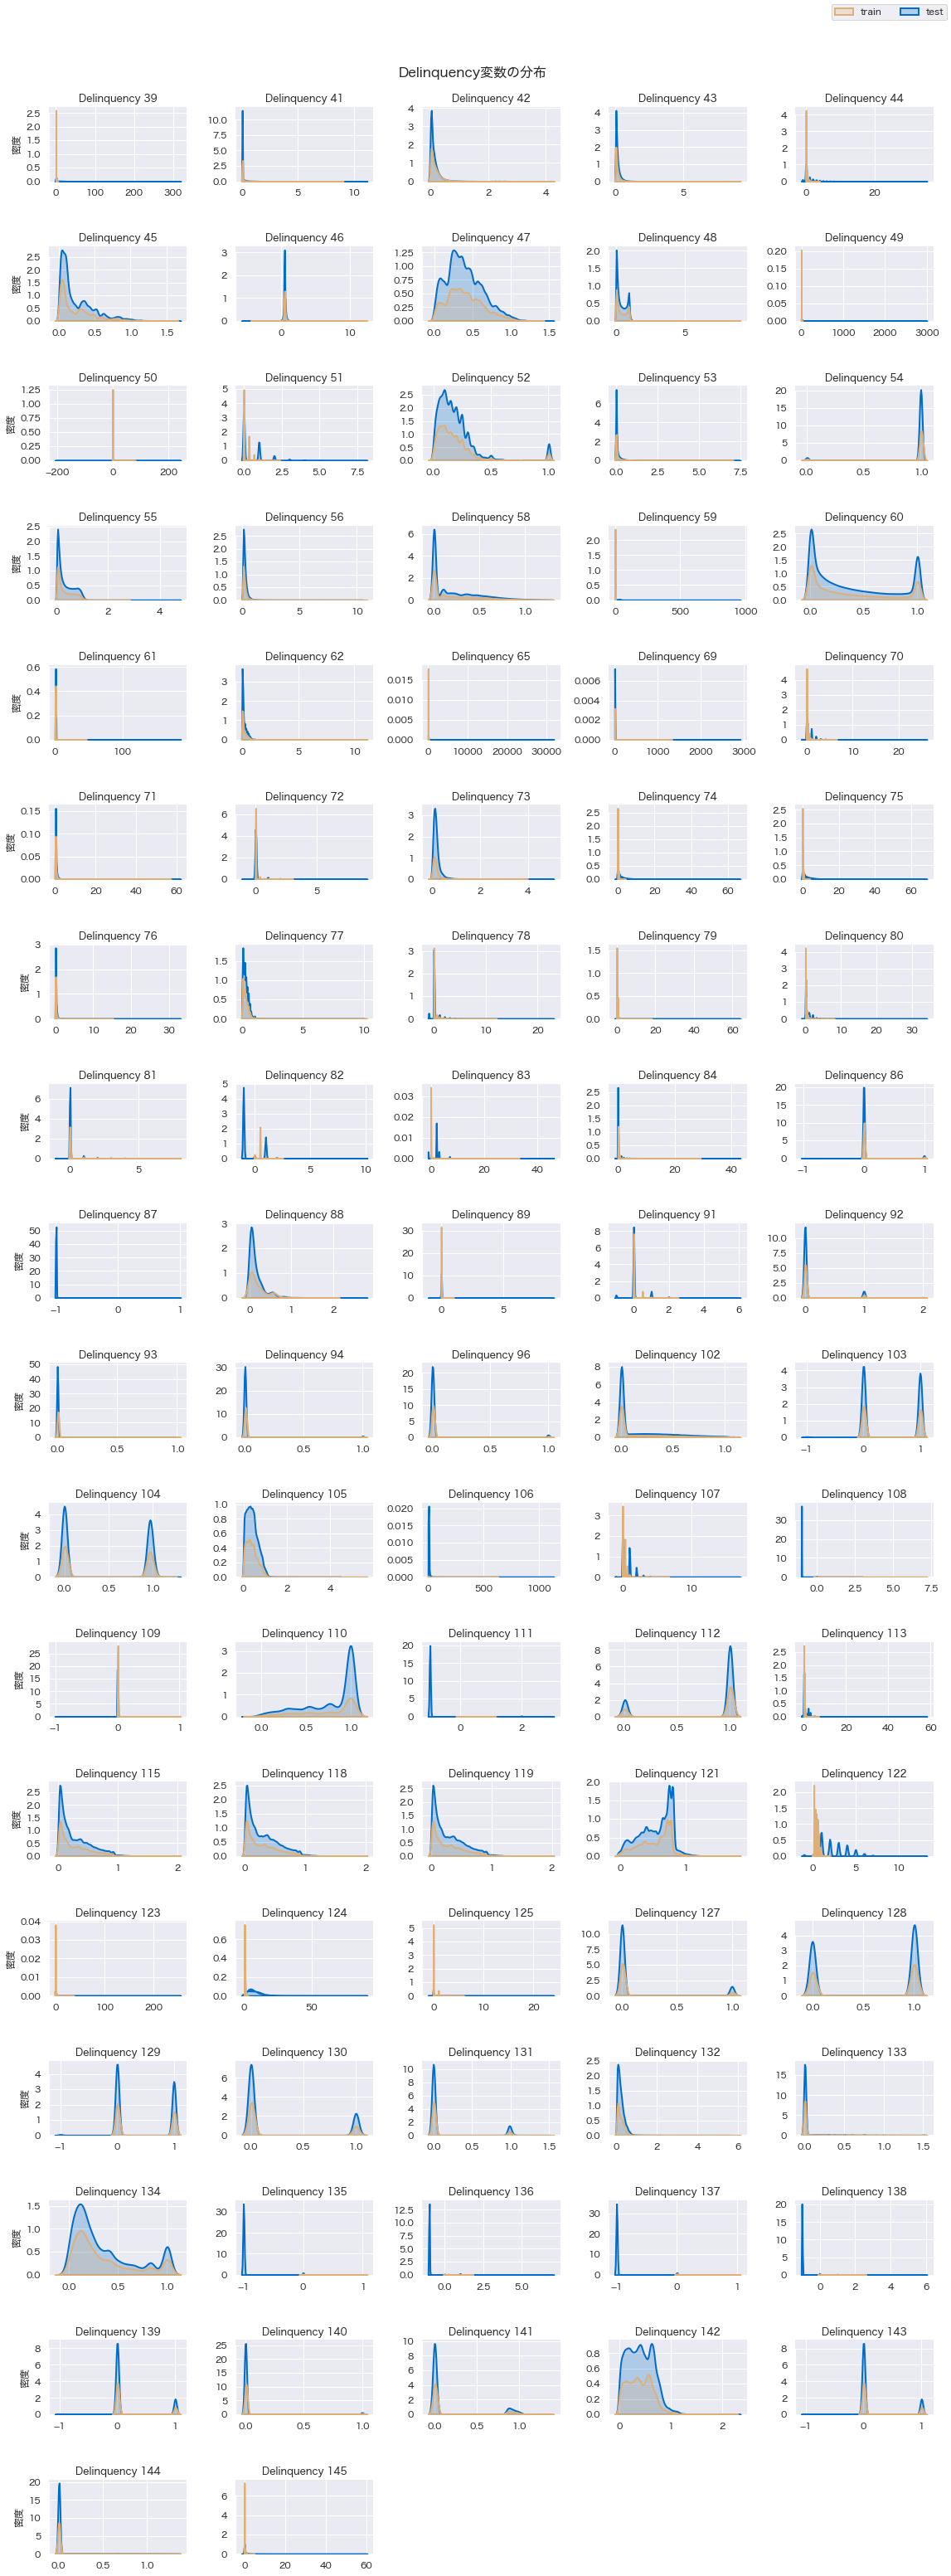

In [29]:
%%time
# パレットカラーの指定
pal = ['#016CC9','#DEB078']

# customer_id, Delinquency_, category　カラムのみ抽出
cols=[col for col in train_test.columns if (col.startswith(('D', 'T', 'c'))) & (col not in cat_cols[:-1])]
sns.set(font='Hiragino Sans')
plot_df=train_test[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54), constrained_layout=True)
# 複数のグラフを含むfigにタイトルをつけたいときは suptitle
fig.suptitle('Delinquency変数の分布', fontsize=16)
row=0
# 横に5つプロットする。18個繰り返したものを col に代入
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    # 5つずつごとに行を変える
    if (i!=0) & (i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='category', palette=pal[::-1], hue_order=[0,1],
                label=['train','test'], data=plot_df,
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title=f'\n\n{column}', xlabel='', ylabel=('密度' if i%5==0 else ''))
# 17行目の3列以降の軸を消す
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels()
fig.legend(labels=['train', 'test'], handles=reversed(handles), ncol=2)
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

## train_labels 予測対象

In [17]:
gc.collect()

0

In [18]:
train_labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [19]:
# 予測するID数は 458193 個らしい
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


## 基本統計量

countで色が違うものはnull値が多いカラム

回帰モデルなどを使用する場合はスケーリングが必要そう

In [ ]:
train.iloc[:, :-1].describe().T.sort_index().style.background_gradient(cmap='GnBu').bar(subset=["max"], color='#F8766D').bar(subset=["mean"], color='#00BFC4')

## 欠損値・異常値確認

In [27]:
# 欠損値の確認関数
def missing_values_summary(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'mis_val_count', 1 : 'mis_val_percent'})
    # mis_val_percent > 1のものに関して、ソートして表示させる
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] > 3].sort_values('mis_val_percent', ascending=False).round(1)
    print ("カラム数：" + str(df.shape[1]) + "\n" + "欠損値のカラム数： " + str(mis_val_table_ren_columns.shape[0]))
    return mis_val_table_ren_columns

In [29]:
missing_values_summary(train1)

カラム数：191
欠損値のカラム数： 44


,mis_val_count,mis_val_percent
Delinquency 87,458268,99.9000
Delinquency 88,458086,99.8000
Delinquency 108,456286,99.4000
Delinquency 111,455235,99.2000
Delinquency 110,455235,99.2000
Balance 39,454808,99.1000
Delinquency 73,454674,99.1000
Balance 42,452771,98.7000
Delinquency 138,442518,96.4000
Delinquency 137,442518,96.4000


# 前処理 + 特徴量エンジニアリング

クラッシュするため、各IDごとのレコード数を減らす

In [42]:
# train データに関して、各IDごと2レコードのみにして、プロットするために category カラムを追加
train2 = train.groupby(customer_ID).tail(2)

# 1000万個以上あったので各IDごと2レコードのみにして、category カラム target カラムを追加
test2 = test.groupby(customer_ID).tail(2)

In [43]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912706 entries, 11 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(185), int64(2), object(4)
memory usage: 692.9+ MB


欠損値率95%以上のカラムを削除する

In [ ]:
miss_val = ['Delinquency 87', 'Delinquency 88', 'Delinquency 108', 'Delinquency 111', 'Delinquency 110', 'Balance 39', 'Delinquency 73', 'Balance 42']

train_tmp = train2.drop(columns=miss_val, axis=1)
test_tmp = test2.drop(columns=miss_val, axis=1)

## 基本統計量の計算

<b>train data</b>

In [52]:
# 改めて連続変数とカテゴリ変数のリスト作成
COLS = list(train.columns[2:190])
cat_cols = ['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126']
# カテゴリー変数に加えて、customer_ID, timestamp のカラムは除く
con_cols = [col for col in COLS if col not in cat_cols and col != ['Spend 2', customer_ID]]

In [47]:
# 平均・分散・最小・最大値・最大・最後の値
train_num_agg = train2.groupby(customer_ID)[con_cols].agg(['mean', 'std', 'min', 'max', 'last'])
# マルチカラムになっているのでそれをシングルカラムにしてあげる
## 参考記事：(https://qiita.com/rinascimento741/items/e2fceb8626ac97ebf49b)
train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
train_num_agg.reset_index(inplace = True)

# customer_IDごとの各カテゴリーに該当する数、最後の値
train_cat_agg = train2.groupby(customer_ID)[cat_cols].agg(['count', 'last', 'nunique'])
# マルチカラムになっているのでそれをシングルカラムにしてあげる
train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
train_cat_agg.reset_index(inplace = True)

<b>test data</b>

In [53]:
# 平均・分散・最小・最大値・最大・最後の値
test_num_agg = test2.groupby(customer_ID)[con_cols].agg(['mean', 'std', 'min', 'max', 'last'])
# マルチカラムになっているのでそれをシングルカラムにしてあげる
## 参考記事：(https://qiita.com/rinascimento741/items/e2fceb8626ac97ebf49b)
test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
test_num_agg.reset_index(inplace = True)

# customer_IDごとの各カテゴリーに該当する数、最後の値
test_cat_agg = test2.groupby(customer_ID)[cat_cols].agg(['count', 'last', 'nunique'])
# マルチカラムになっているのでそれをシングルカラムにしてあげる
test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
test_cat_agg.reset_index(inplace = True)

: 

: 

In [48]:
# 進捗状況を可視化するメソッドをdataframe オブジェクトに追加する
tqdm.pandas()
# 計算コスト削減のためにfloat64をfloat32に変換
cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
train_num_agg.loc[:,cols] = train_num_agg.loc[:,cols].progress_apply(lambda x: x.astype(np.float32))

# 計算コスト削減のためにint64をint32に変換
cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
train_cat_agg.loc[:,cols] = train_cat_agg.loc[:,cols].progress_apply(lambda x: x.astype(np.int32))

100%|██████████| 22/22 [00:00<00:00, 2253.85it/s]


## 差分の計算

以下の方法がメモリを節約しながらかなり早くできるらしい。

In [51]:
train_diff = train2.loc[:,con_cols+[customer_ID]].groupby([customer_ID]).progress_apply(lambda x:np.diff(x.values[-2:,:], axis=0).squeeze().astype(np.float32))
index = train_diff.index
cols = [col + '_diff1' for col in train2[con_cols].columns]
train_diff = pd.DataFrame(train_diff.values.tolist(), columns = cols)
train_diff[customer_ID] = index

100%|██████████| 458913/458913 [00:13<00:00, 34412.15it/s]


以下の方法はnotebookに記載されていた方法だが、若干重い。自分のCPUではクラッシュしてしまうことがある

In [37]:
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    # `tqdm` customer_IDごとでグループ分けをした groupby オブジェクトをcustomer_ID, dfに分ける
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        df1.append(
            # 各変数 ごとに同じcustomer_ID内で前のレコードとの差分を出して、そのうち一番最後のレコードを取得する
            df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        )
        customer_ids.append(customer_id)
    # よくわからん
    df1 = np.concatenate(df1, axis = 0)
    # カラム名に `_diff1`と付けた上で、dataframe型に変える
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # customer_IDカラムを追加する
    df1['customer_ID'] = customer_ids
    return df1

## マージ

In [ ]:
# train_num_agg, train_cat_agg, train_diff, train_labels をマージして
train2 = pd.merge(train_num_agg, train_cat_agg, how='inner', on=customer_ID).merge(train_diff, how='inner', on=customer_ID).merge(train_labels, how='inner', on=customer_ID)

del train_num_agg, train_cat_agg, train_diff
gc.collect()

## カテゴリ変数の変換

カテゴリデータは基本的にそのまま特徴量として扱えないので、数値化する

* One-Hot Encoding -> gbdt系以外（線形モデル etc..）におすすめ
* Label Encoding-> gbdt系 にもおすすめ\
[【sklearn】LabelEncoderの使い方を丁寧に](https://gotutiyan.hatenablog.com/entry/2020/09/08/122621)
* Target Encoding -> gbdt系にはより効果的らしい\
[Target Encoding はなぜ有効なのか](https://speakerdeck.com/hakubishin3/target-encoding-hanazeyou-xiao-nafalseka)

## データマージ

# 学習・予測・サブミットファイル作成

## モデル構築

## モデル評価

## サブミットファイル作成